In [ ]:
!pip install fastcoref
from sentence_transformers import SentenceTransformer, util
from fastcoref import FCoref
from typing import List, Dict, Tuple
import spacy
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
nlp = spacy.load("en_core_web_sm")
sentModel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #smaller models are not as accurate
corefmodel = FCoref(device='cpu')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00
  Created wheel for fastcoref: filename=fastcoref-2.1.6-py3-none-any.whl size=31254 sha256=04fc43cd6fb7e0b54c4373a3e6dd83756723fd64e1d812627f13509fa559655d
  Sto

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

In [ ]:
text_test = open("sample.txt").read()

In [ ]:
def replace_mentions(text: str) -> str:
    """
    Resolves pronouns in text using FastCoref and replaces them with their referents.
    Returns the resolved text.
    """
    # FastCoref requires list input
    predictions = corefmodel.predict([text])
    prediction = predictions[0]  # Get first (only) prediction

    print(f"\n📌 Original: {text}")

    # Get the actual span clusters - this is the key fix!
    # Use get_clusters(as_strings=False) to get span coordinates
    try:
        # Try different ways to access clusters based on FastCoref version
        if hasattr(prediction, 'get_clusters'):
            clusters = prediction.get_clusters(as_strings=False)
        elif hasattr(prediction, 'clusters'):
            clusters = prediction.clusters
        else:
            # Fallback - access clusters directly from prediction attributes
            clusters = getattr(prediction, '_clusters', [])
    except Exception as e:
        print(f"Error accessing clusters: {e}")
        return text

    # For debugging - print raw clusters
    print(f"🔍 Raw clusters: {clusters}")

    # Build replacement map: {(start, end) -> replacement_text}
    replacements: Dict[Tuple[int, int], str] = {}

    for cluster in clusters:
        if not cluster or len(cluster) < 2:  # Need at least 2 mentions for coreference
            continue

        print(f"🔗 Processing cluster: {cluster}")

        # Find the best referent (usually the first non-pronoun mention)
        main_referent = None
        main_text = ""

        for span in cluster:
            if not isinstance(span, (tuple, list)) or len(span) != 2:
                continue

            start, end = span
            span_text = text[start:end]

            # Skip pronouns for main referent selection
            if span_text.lower() not in {'it', 'he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'its', 'their'}:
                main_referent = span
                main_text = span_text
                break

        # If no non-pronoun referent found, use the first mention
        if main_referent is None and cluster:
            main_referent = cluster[0]
            main_text = text[main_referent[0]:main_referent[1]]

        print(f"   📍 Main referent: '{main_text}' at {main_referent}")

        # Replace pronouns in this cluster
        for span in cluster:
            if not isinstance(span, (tuple, list)) or len(span) != 2:
                continue

            start, end = span
            mention_text = text[start:end]

            # Only replace pronouns, and don't replace the main referent with itself
            if (mention_text.lower() in {'it', 'he', 'she', 'they', 'him', 'her', 'them'}
                and span != main_referent):
                replacements[(start, end)] = main_text
                print(f"   🔄 Will replace '{mention_text}' ({start}-{end}) with '{main_text}'")

    # Apply replacements in reverse order (to preserve positions)
    resolved_text = text
    for (start, end) in sorted(replacements.keys(), reverse=True):
        resolved_text = resolved_text[:start] + replacements[(start, end)] + resolved_text[end:]

    print(f"✅ Resolved: {resolved_text}")
    return resolved_text



print("=== Testing Version 1 ===")
newtext = replace_mentions(text_test)

=== Testing Version 1 ===


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Original: Members of the faculty and members of the student body of this great institution of learning; ladies and gentlemen.
Now there are several things that one could talk about before such a large, concerned, and enlightened audience. There are so many problems facing our nation and our world, that one could just take off anywhere. But today I would like to talk mainly about the race problems since I'll have to rush right out and go to New York to talk about Vietnam tomorrow. and I've been talking about it a great deal this week and weeks before that.
But I'd like to use a subject from which to speak this afternoon, the Other America.
And I use this subject because there are literally two Americas. One America is beautiful for situation. And, in a sense, this America is overflowing with the milk of prosperity and the honey of opportunity. This America is the habitat of millions of people who have food and material necessities for their bodies; and culture and education for their

In [ ]:
def split_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

def should_merge(s1, s2, soft_conj=("and", "but", "because"), embed_sim_threshold=0.35):
    if not s2.lower().startswith(tuple(w + ' ' for w in soft_conj)):
        return False
    e1 = sentModel.encode(s1, convert_to_tensor=True)
    e2 = sentModel.encode(s2, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(e1, e2).item()
    return sim >= embed_sim_threshold

# Merge adjacent related sentences
def smart_merge_conj_embed(sentences, soft_conj=("and", "but", "because"), embed_sim_threshold=0.35):
    merged = []
    buffer = sentences[0]
    for i in range(1, len(sentences)):
        curr = sentences[i]
        if should_merge(buffer, curr, soft_conj, embed_sim_threshold):
            buffer += " " + curr
        else:
            merged.append(buffer.strip())
            buffer = curr
    merged.append(buffer.strip())
    return merged

def process_text(text):
    sentences = split_sentences(text)
    sentences = [s for s in sentences if len(s.split()) >= 3]
    merged_sentences = smart_merge_conj_embed(sentences)
    return merged_sentences

result = process_text(text_test)

for i, s in enumerate(result):
    print(f"[{i}] {s}")


[0] Members of the faculty and members of the student body of this great institution of learning; ladies and gentlemen.
[1] Now there are several things that one could talk about before such a large, concerned, and enlightened audience.
[2] There are so many problems facing our nation and our world, that one could just take off anywhere.
[3] But today I would like to talk mainly about the race problems since I'll have to rush right out and go to New York to talk about Vietnam tomorrow. and I've been talking about it a great deal this week and weeks before that. But I'd like to use a subject from which to speak this afternoon, the Other America. And I use this subject because there are literally two Americas.
[4] One America is beautiful for situation.
[5] And, in a sense, this America is overflowing with the milk of prosperity and the honey of opportunity.
[6] This America is the habitat of millions of people who have food and material necessities for their bodies; and culture and educ

Pos   5: Progress=  0.1% | Staleness=0.00 | Saturation=0.00 | Threshold=0.62 | EstLen=50
Pos  10: Progress=  1.0% | Staleness=0.00 | Saturation=0.36 | Threshold=0.59 | EstLen=50
Pos  15: Progress=  2.9% | Staleness=0.00 | Saturation=0.49 | Threshold=0.56 | EstLen=40
Pos  16: Progress=  5.2% | Staleness=0.11 | Saturation=0.51 | Threshold=0.55 | EstLen=40
Pos  20: Progress=  9.5% | Staleness=0.50 | Saturation=0.55 | Threshold=0.53 | EstLen=40
Pos  24: Progress= 14.1% | Staleness=0.54 | Saturation=0.53 | Threshold=0.51 | EstLen=40
Pos  28: Progress= 19.6% | Staleness=0.76 | Saturation=0.53 | Threshold=0.50 | EstLen=40
Pos  32: Progress= 25.0% | Staleness=0.75 | Saturation=0.54 | Threshold=0.48 | EstLen=40
Pos  36: Progress= 30.9% | Staleness=0.90 | Saturation=0.62 | Threshold=0.47 | EstLen=40
Pos  40: Progress= 36.7% | Staleness=1.00 | Saturation=0.65 | Threshold=0.45 | EstLen=40
Pos  44: Progress= 42.1% | Staleness=1.00 | Saturation=0.56 | Threshold=0.44 | EstLen=40
Pos  48: Progress= 47

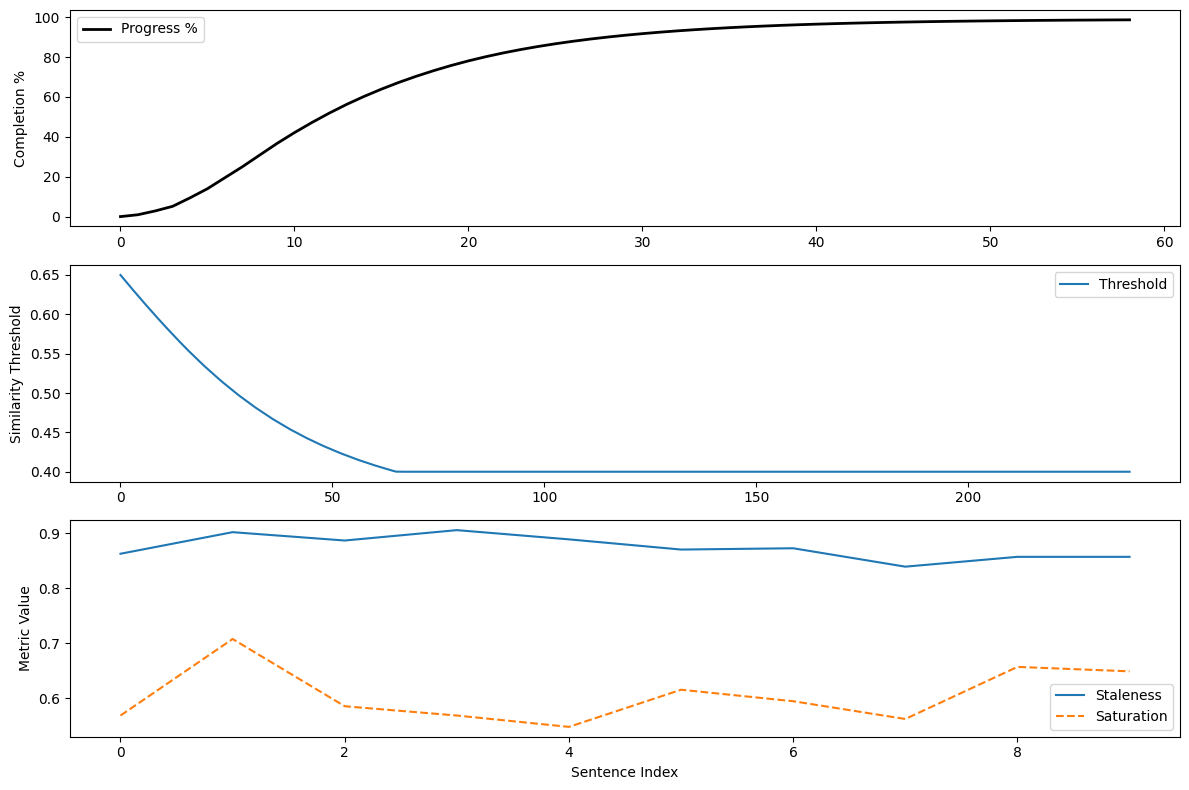

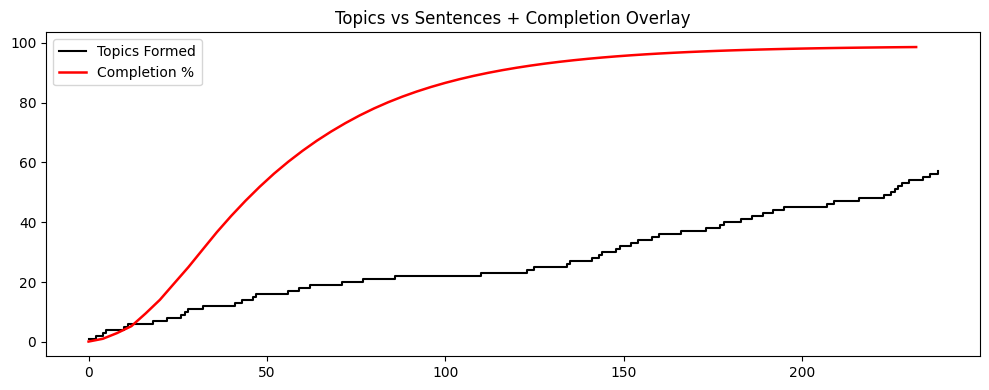


Final Groups:

Group 1:
  - Members of the faculty and members of the student body of this great institution of learning; ladies and gentlemen.

Group 2:
  - Now there are several things that one could talk about before such a large, concerned, and enlightened audience.
  - Now there's another thing that I'd like to mention as I talk about the massive action program and time will not permit me to go into specific programmatic action to any great degree.
  - It has strengthened the forces of reaction in our country and has brought to the forefront the military-industrial complex that even President Eisenhower warned us against at one time.

Group 3:
  - There are so many problems facing our nation and our world, that one could just take off anywhere.

Group 4:
  - But today I would like to talk mainly about the race problems since I'll have to rush right out and go to New York to talk about Vietnam tomorrow. and I've been talking about it a great deal this week and weeks before that. B

In [ ]:
def compute_trend(history, window=5):
    if len(history) < window:
        return 0.0
    x = np.arange(window)
    y = np.array(list(history)[-window:])
    return np.polyfit(x, y, 1)[0]

def enhanced_staleness(groups, current_index, history=deque(maxlen=10)):
    base = sum(1 for g in groups if current_index - max(g) > 15) / len(groups) if groups else 0
    age_factor = sum(current_index - min(g) for g in groups) / (100 * len(groups)) if groups else 0
    history.append(base)
    trend = compute_trend(history)
    return min(1.0, base * (1.2 + age_factor) + 0.3 * trend)

def enhanced_saturation(groups, current_index, history=deque(maxlen=10)):
    if current_index < 10 or not groups:
        return 0.0

    # New: Calculate population balance across topics
    group_sizes = [len(g) for g in groups]
    avg_size = np.mean(group_sizes)
    size_deviation = np.std(group_sizes) / avg_size if avg_size > 0 else 0

    # New: Calculate topic vitality (recent additions)
    vital_topics = 0
    for g in groups:
        recent_additions = sum(1 for sent_idx in g if current_index - sent_idx < 8)
        if recent_additions > 0:
            vital_topics += 1

    lookback = min(20, current_index//2)
    base = sum(1 for g in groups if min(g) >= current_index - lookback) / len(groups)
    depth = np.mean([min(1, len(g)/8) for g in groups if max(g) >= current_index - 5]) if any(g[-1] >= current_index - 5 for g in groups) else 0

    population_factor = min(1.0, size_deviation * 2)
    vitality_factor = 1 - (vital_topics / len(groups)) if groups else 0

    saturation = min(1.0,
        0.3*base + 0.3*depth + 0.2*population_factor + 0.2*vitality_factor
    )

    history.append(saturation)
    trend = compute_trend(history)
    return min(1.0, saturation + 0.1*trend)

def estimate_speech_length(groups, current_index):
    if current_index < 15:
        return 50
    topic_rate = len(groups) / current_index
    return min(400, max(40, int(3.8 / max(topic_rate, 0.01))))

def calculate_progress(staleness, saturation, pos, est_length):
    time_weight = min(1.0, pos / est_length)
    staleness_weight = 0.4 + 0.3 * time_weight
    saturation_weight = 0.6 - 0.3 * time_weight
    combined = (staleness_weight * staleness + saturation_weight * saturation)
    progress = 100 * (1 - np.exp(-2.5 * combined * (pos/est_length)))
    return min(99, max(1, progress))

def linear_grouping_quantified(sentences, model, initial_threshold=0.65, min_threshold=0.4):
    embeddings, groups, group_embeddings = [], [], []
    threshold_history, progress_history = [], []
    staleness_history, saturation_history = deque(maxlen=10), deque(maxlen=10)
    current_window, predicted_length, smoothed_progress = 5, 50, 0

    for i, sentence in enumerate(sentences):
        new_embedding = model.encode(sentence, convert_to_tensor=True)
        embeddings.append(new_embedding)

        if i == 0:
            groups.append([0])
            group_embeddings.append(new_embedding)
            threshold_history.append(initial_threshold)
            continue

        current_threshold = max(min_threshold, threshold_history[-1] * (1 - 0.01 * (1 - smoothed_progress/100)))

        best_sim, best_group = -1, None
        for group_idx, group_embed in enumerate(group_embeddings):
            sim = util.pytorch_cos_sim(new_embedding, group_embed).item()
            if sim > best_sim:
                best_sim, best_group = sim, group_idx

        if best_sim >= current_threshold:
            groups[best_group].append(i)
            group_embeddings[best_group] = torch.mean(torch.stack([embeddings[idx] for idx in groups[best_group]]), dim=0)
        else:
            groups.append([i])
            group_embeddings.append(new_embedding)

        threshold_history.append(current_threshold)

        if i % current_window == 0:
            predicted_length = estimate_speech_length(groups, i)
            current_window = max(3, min(10, int(0.1 * predicted_length)))

            staleness = enhanced_staleness(groups, i, staleness_history)
            saturation = enhanced_saturation(groups, i, saturation_history)
            current_progress = calculate_progress(staleness, saturation, i, predicted_length)
            smoothed_progress = 0.9 * smoothed_progress + 0.1 * current_progress
            progress_history.append(smoothed_progress)

            print(f"Pos {i:3d}: Progress={smoothed_progress:5.1f}% | "
                  f"Staleness={staleness:.2f} | "
                  f"Saturation={saturation:.2f} | "
                  f"Threshold={current_threshold:.2f} | "
                  f"EstLen={predicted_length}")

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(progress_history, label='Progress %', color='black', linewidth=2)
    plt.ylabel("Completion %")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(threshold_history, label='Threshold')
    plt.ylabel("Similarity Threshold")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot([m[0] for m in zip(staleness_history, saturation_history)], label='Staleness')
    plt.plot([m[1] for m in zip(staleness_history, saturation_history)], label='Saturation', linestyle='--')
    plt.xlabel("Sentence Index")
    plt.ylabel("Metric Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sentence_indices = list(range(len(sentences)))
    topic_counts = [len([g for g in groups if max(g) <= i]) for i in sentence_indices]
    plt.step(sentence_indices, topic_counts, where='post', label='Topics Formed', color='black')
    x_vals = list(range(0, len(progress_history)*current_window, current_window))
    plt.plot(x_vals, progress_history, label='Completion %', color='red', linewidth=1.8)
    plt.title("Topics vs Sentences + Completion Overlay")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nFinal Groups:")
    for idx, group in enumerate(groups):
        print(f"\nGroup {idx+1}:")
        for sent_idx in group:
            print(f"  - {sentences[sent_idx]}")

linear_grouping_quantified(result, sentModel)